In [187]:
# Uniswap V3 Rebalance Cost Calculator
# This notebook calculates the total cost of rebalances for different range percentages

# Configuration
SYMBOL = "ARBUSDC"
pool_addr = "0xcDa53B1F66614552F834cEeF361A8D12a0B8DaD8"
deposit_amount_usd = 10000
is_pair_toggled = False

# Rebalance cost assumptions for Arbitrum
GAS_PRICE_GWEI = 0.0260  # Current Arbitrum gas price in gwei
GAS_UNITS_REBALANCE = 300000  # Estimated gas units for withdraw + swap + deposit
ETH_PRICE_USD = 3200  # Current ETH price for gas cost calculation
GAS_COST_USD = (GAS_PRICE_GWEI * GAS_UNITS_REBALANCE * ETH_PRICE_USD) / 1e9  # Convert to USD

print(f"Estimated gas cost per rebalance: ${GAS_COST_USD:.4f}")

# Pool fee will be loaded from token data (e.g., 0.3% for most pools)


Estimated gas cost per rebalance: $0.0250


In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import glob
import sys
import pathlib
from decimal import getcontext
import datetime as dt

# Add univ3_calculator to path for imports
sys.path.append(str(pathlib.Path.cwd() / 'univ3_calculator'))
from uniswapv3_calculator import UniswapV3Calculator

# Set high precision for accurate calculations
getcontext().prec = 50

# Set up matplotlib style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# lowercase pool address
pool_addr = pool_addr.lower()

print("Libraries imported successfully!")
print("Ready to calculate rebalance costs!")


Libraries imported successfully!
Ready to calculate rebalance costs!


In [189]:
# Load pool data
def load_pool_data(pool_address):
    """Load pool data from CSV and JSON files"""
    pool_addr_lower = pool_address.lower()
    
    try:
        # Load pool day data
        pool_day_data = pd.read_csv(f'{pool_addr_lower}_pool_day_data.csv')
        print(f"✅ Loaded pool day data: {len(pool_day_data)} records")
        
        # Load pool ticks data
        pool_ticks_data = pd.read_csv(f'{pool_addr_lower}_pool_ticks_data.csv')
        print(f"✅ Loaded pool ticks data: {len(pool_ticks_data)} records")
        
        # Load token data
        with open(f'{pool_addr_lower}_token_data.json', 'r') as f:
            token_data = json.load(f)
        print(f"✅ Loaded token data for pool: {token_data['pool']['id']}")
        
        # Verify pool address matches
        if token_data['pool']['id'] != pool_addr_lower:
            raise ValueError(f"Pool address mismatch: {token_data['pool']['id']} != {pool_addr_lower}")
            
        return pool_day_data, pool_ticks_data, token_data
        
    except FileNotFoundError as e:
        print(f"❌ Error: Required data files not found for pool {pool_address}")
        print(f"Make sure you have run the data collection notebook first.")
        print(f"Missing file: {e}")
        return None, None, None
    except Exception as e:
        print(f"❌ Error loading pool data: {e}")
        return None, None, None

# Load pool data
pool_day_data, pool_ticks_data, token_data = load_pool_data(pool_addr)

if pool_day_data is not None:
    # Extract token information
    token0_decimal = int(token_data['token0']['decimals'])
    token1_decimal = int(token_data['token1']['decimals'])
    fee_tier = int(token_data['pool']['feeTier']) / 1_000_000
    price_usd_x = float(token_data['token0']['priceUSD'])
    price_usd_y = float(token_data['token1']['priceUSD'])
    
    print(f"\n📊 Pool Information:")
    print(f"Token0: {token_data['token0']['symbol']} (${price_usd_x:.2f})")
    print(f"Token1: {token_data['token1']['symbol']} (${price_usd_y:.2f})")
    print(f"Fee Tier: {fee_tier*100}%")
    print(f"Decimals: {token0_decimal}, {token1_decimal}")
else:
    print("❌ Failed to load pool data. Please check the pool address and data files.")


✅ Loaded pool day data: 90 records
✅ Loaded pool ticks data: 2782 records
✅ Loaded token data for pool: 0xcda53b1f66614552f834ceef361a8d12a0b8dad8

📊 Pool Information:
Token0: ARB ($0.43)
Token1: USDC ($1.00)
Fee Tier: 0.05%
Decimals: 18, 6


In [190]:
# Load price data for rebalancing simulation
def find_price_csv():
    """Find price CSV files in the current directory"""
    csv_files = glob.glob(f"{SYMBOL}_hourly_data_*.csv")
    return csv_files

def load_price_data(filename=None):
    """Load price data from CSV file"""
    
    if filename is None:
        # Try to find price CSV files automatically
        csv_files = find_price_csv()
        
        if not csv_files:
            print(f"No {SYMBOL} CSV files found in current directory.")
            print("Please ensure you have the hourly price data file.")
            return None
        
        # Use the most recent file
        filename = max(csv_files, key=os.path.getctime)
        print(f"Found {len(csv_files)} price CSV file(s)")
        print(f"Using most recent file: {filename}")
    
    try:
        # Load the CSV file
        df = pd.read_csv(filename)
        
        # Convert timestamp columns to datetime
        df['open_time'] = pd.to_datetime(df['open_time'])
        df['close_time'] = pd.to_datetime(df['close_time'])
        
        # Ensure data types are correct
        price_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
                         'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
        for col in price_columns:
            if col in df.columns:
                df[col] = df[col].astype(float)
        
        # Sort by open_time to ensure chronological order
        df = df.sort_values('open_time').reset_index(drop=True)
        
        print(f"✅ Successfully loaded {SYMBOL} price data!")
        print(f"📊 Dataset: {len(df):,} hourly records")
        print(f"📅 Period: {df['open_time'].min().strftime('%Y-%m-%d %H:%M')} to {df['open_time'].max().strftime('%Y-%m-%d %H:%M')}")
        
        return df
        
    except FileNotFoundError:
        print(f"❌ Error: File '{filename}' not found.")
        print("Please check the filename and try again.")
        return None
    except Exception as e:
        print(f"❌ Error loading price data: {e}")
        return None

# Load the price data
price_df = load_price_data()

if price_df is not None:
    print(f"\n🎯 Price data loaded successfully! Ready for rebalance cost analysis.")
    print(f"Current price: {price_df.iloc[0]['close']:.6f}")
else:
    print("❌ Failed to load price data. Cannot proceed with rebalance cost analysis.")


Found 1 price CSV file(s)
Using most recent file: ARBUSDC_hourly_data_20240630_20250630.csv
✅ Successfully loaded ARBUSDC price data!
📊 Dataset: 8,761 hourly records
📅 Period: 2024-06-29 17:00 to 2025-06-29 17:00

🎯 Price data loaded successfully! Ready for rebalance cost analysis.
Current price: 0.787300


In [191]:
# Rebalance cost calculation functions
from collections import namedtuple

# Define Position structure to track LP position state
Position = namedtuple('Position', 'price price_lower price_upper liquidity amount0 amount1')

def calculate_token_amounts_at_price(calculator, price, price_lower, price_upper, deposit_usd, price_usd_x, price_usd_y):
    """Calculate token amounts needed for a position at a specific price"""
    try:
        amount0, amount1, liquidity = calculator.get_tokens_amount_from_deposit_amount_usd(
            price, price_lower, price_upper, price_usd_x, price_usd_y, deposit_usd
        )
        return amount0, amount1, liquidity
    except Exception as e:
        print(f"Error calculating token amounts at price {price}: {e}")
        return 0, 0, 0

def calculate_initial_swap_cost(target_amount0, target_amount1, deposit_usd, pool_fee_tier, price_usd_x, price_usd_y):
    """
    Calculate the swap cost needed to create the initial LP position from USD.
    
    Calculates exact swap fees based on required token amounts.
    Assumes starting with USD and needing to acquire both tokens.
    
    Args:
        target_amount0: Required amount of token0 for the LP position
        target_amount1: Required amount of token1 for the LP position  
        deposit_usd: Total USD amount being deposited
        pool_fee_tier: Pool fee tier (e.g., 0.0005 for 0.05%)
        price_usd_x: USD price of token0
        price_usd_y: USD price of token1
    
    Returns:
        initial_swap_fee: Fee paid to acquire the tokens from USD
    """
    
    # Calculate USD value needed for each token
    usd_for_token0 = target_amount0 * price_usd_x
    usd_for_token1 = target_amount1 * price_usd_y
    
    # Determine which token requires more USD value - this will be the larger swap
    # Assume we start with USD and need to swap to get both tokens
    if usd_for_token0 > usd_for_token1:
        # Need more token0, so swap more USD for token0
        primary_swap_usd = usd_for_token0
        secondary_swap_usd = usd_for_token1
    else:
        # Need more token1, so swap more USD for token1  
        primary_swap_usd = usd_for_token1
        secondary_swap_usd = usd_for_token0
    
    # Calculate swap fees for both swaps
    # Most efficient route: USD -> primary token (larger amount), then small secondary swap
    primary_swap_fee = primary_swap_usd * pool_fee_tier
    secondary_swap_fee = secondary_swap_usd * pool_fee_tier
    
    total_initial_swap_fee = primary_swap_fee + secondary_swap_fee
    
    return total_initial_swap_fee

def calculate_actual_token_amounts_after_withdrawal(calculator, current_price, price_lower, price_upper, liquidity_amount):
    """
    Calculate actual token amounts after withdrawing liquidity at current price.
    Uses proper Uniswap V3 math to determine withdrawal amounts based on current price position.
    """
    from decimal import Decimal
    
    try:
        # Convert to Decimal for precision
        P = Decimal(str(current_price))
        Pl = Decimal(str(price_lower))
        Pu = Decimal(str(price_upper))
        L = Decimal(str(liquidity_amount))
        
        # Calculate sqrt prices using calculator's method for consistency
        sqrt_P = calculator.get_sqrt_price_x96(float(P))
        sqrt_Pl = calculator.get_sqrt_price_x96(float(Pl))
        sqrt_Pu = calculator.get_sqrt_price_x96(float(Pu))
        
        if P <= Pl:
            # Price below range - all liquidity in token0
            # Correct formula: amount0 = L * (sqrt_Pu - sqrt_Pl) / (sqrt_Pu * sqrt_Pl) * Q96
            amount0 = calculator.mul_div(L * calculator.Q96, sqrt_Pu - sqrt_Pl, sqrt_Pu * sqrt_Pl)
            amount1 = 0
        elif P >= Pu:
            # Price above range - all liquidity in token1
            # Correct formula: amount1 = L * (sqrt_Pu - sqrt_Pl) / Q96  
            amount0 = 0
            amount1 = calculator.mul_div(L, sqrt_Pu - sqrt_Pl, calculator.Q96)
        else:
            # Price in range - mixed position
            # amount0 = L * (sqrt_Pu - sqrt_P) / (sqrt_Pu * sqrt_P) * Q96
            # amount1 = L * (sqrt_P - sqrt_Pl) / Q96
            amount0 = calculator.mul_div(L * calculator.Q96, sqrt_Pu - sqrt_P, sqrt_Pu * sqrt_P)
            amount1 = calculator.mul_div(L, sqrt_P - sqrt_Pl, calculator.Q96)
        
        return float(max(0, amount0)), float(max(0, amount1))
        
    except Exception as e:
        print(f"Error in withdrawal calculation: {e}")
        # Fallback: use proportional distribution based on original amounts
        try:
            # Get original token distribution at middle of range
            mid_price = (price_lower + price_upper) / 2
            fallback_amount0, fallback_amount1, _ = calculator.get_tokens_amount_from_deposit_amount_usd(
                mid_price, price_lower, price_upper, 1.0, 1.0, 1000
            )
            return fallback_amount0, fallback_amount1
        except:
            return 0, 0

def calculate_swap_needed(withdrawn_amount0, withdrawn_amount1, required_amount0, required_amount1, price_usd_x, price_usd_y):
    """
    Calculate the swap needed to go from withdrawn amounts to required amounts.
    
    Determines the exact swap needed to rebalance from actual withdrawn tokens
    to the required tokens for the new LP position.
    
    Returns (swap_amount, swap_direction, swap_value_usd)
    swap_direction: 'token0_to_token1' or 'token1_to_token0'
    """
    
    # Calculate the difference in token amounts needed
    diff_amount0 = required_amount0 - withdrawn_amount0  # How much more/less token0 needed
    diff_amount1 = required_amount1 - withdrawn_amount1  # How much more/less token1 needed
    
    # Handle edge case: need more of both tokens or have excess of both
    if (diff_amount0 > 0 and diff_amount1 > 0) or (diff_amount0 < 0 and diff_amount1 < 0):
        # Cannot satisfy both requirements through swapping alone
        # Return minimal swap or external funding needed
        return 0, 'external_funding_needed', 0
    
    # Determine swap direction and amount
    # If we need more token0 and have excess token1, swap token1 -> token0
    # If we need more token1 and have excess token0, swap token0 -> token1
    
    if diff_amount0 > 0 and diff_amount1 < 0:
        # Need more token0, have excess token1 -> swap token1 to token0
        # Swap the smaller of: excess token1 OR USD equivalent of needed token0
        excess_token1 = abs(diff_amount1)
        needed_token0_usd = diff_amount0 * price_usd_x
        needed_token0_in_token1 = needed_token0_usd / price_usd_y
        
        swap_amount = min(excess_token1, needed_token0_in_token1)
        swap_direction = 'token1_to_token0'
        swap_value_usd = swap_amount * price_usd_y
        
    elif diff_amount1 > 0 and diff_amount0 < 0:
        # Need more token1, have excess token0 -> swap token0 to token1
        excess_token0 = abs(diff_amount0)
        needed_token1_usd = diff_amount1 * price_usd_y  
        needed_token1_in_token0 = needed_token1_usd / price_usd_x
        
        swap_amount = min(excess_token0, needed_token1_in_token0)
        swap_direction = 'token0_to_token1'
        swap_value_usd = swap_amount * price_usd_x
        
    elif diff_amount0 > 0:
        # Need more token0, swap some token1 for it
        needed_token0_usd = diff_amount0 * price_usd_x
        swap_amount = needed_token0_usd / price_usd_y  # token1 amount to swap
        swap_direction = 'token1_to_token0'
        swap_value_usd = needed_token0_usd
        
    elif diff_amount1 > 0:
        # Need more token1, swap some token0 for it  
        needed_token1_usd = diff_amount1 * price_usd_y
        swap_amount = needed_token1_usd / price_usd_x  # token0 amount to swap
        swap_direction = 'token0_to_token1'
        swap_value_usd = needed_token1_usd
        
    else:
        # No significant swap needed
        swap_amount = 0
        swap_direction = 'no_swap_needed'
        swap_value_usd = 0
    
    return swap_amount, swap_direction, swap_value_usd

def calculate_rebalance_cost(old_amount0, old_amount1, new_amount0, new_amount1, pool_fee_tier, gas_cost_usd, price_usd_x, price_usd_y):
    """
    Calculate the actual cost of rebalancing from old position to new position.
    
    This properly simulates:
    1. Withdrawing liquidity (getting back tokens in current ratio)
    2. Swapping tokens to achieve new target ratio  
    3. Applying pool fee to the swap
    4. Adding gas costs
    
    Args:
        old_amount0, old_amount1: Token amounts from withdrawing old position
        new_amount0, new_amount1: Required token amounts for new position
        pool_fee_tier: Pool fee rate (e.g., 0.0005 for 0.05%)
        gas_cost_usd: Gas cost for the rebalance transaction
        price_usd_x, price_usd_y: USD prices of tokens
    
    Returns:
        (total_cost, swap_value_usd, swap_fee_usd, swap_direction)
    """
    
    # Calculate what swap is needed
    swap_amount, swap_direction, swap_value_usd = calculate_swap_needed(
        old_amount0, old_amount1, new_amount0, new_amount1, price_usd_x, price_usd_y
    )
    
    # Calculate swap fee (pool fee tier applied to swap amount)
    swap_fee_usd = swap_value_usd * pool_fee_tier
    
    # Total rebalance cost = gas + swap fees
    total_cost = gas_cost_usd + swap_fee_usd
    
    return total_cost, swap_value_usd, swap_fee_usd, swap_direction

def simulate_rebalancing_with_costs(price_df, calculator, range_pct, deposit_usd, pool_fee_tier, gas_cost_usd, price_usd_x, price_usd_y):
    """
    Simulate rebalancing with cost calculation for a given range percentage.
    
    This includes:
    1. Initial swap fee to create the first LP position from USD
    2. All rebalancing swap fees when ranges need to be updated
    3. Gas costs for each transaction
    
    Args:
        price_df: DataFrame with price data
        calculator: UniswapV3Calculator instance
        range_pct: Range percentage (e.g., 0.1 for 10%)
        deposit_usd: Initial deposit amount in USD
        pool_fee_tier: Pool fee tier for swap cost calculations
        gas_cost_usd: Gas cost per transaction
        price_usd_x, price_usd_y: USD prices of tokens
    
    Returns:
        dict: Results including number of rebalances, total costs, etc.
    """
    if price_df is None or price_df.empty:
        return None
    
    prices = price_df['close'].values
    timestamps = price_df['open_time'].values
    
    rebalances = []
    current_center = prices[0]  # Start with first price as center
    half_range = range_pct / 2
    
    rebalance_count = 0
    periods = []  # Track how long each range lasted
    current_period_start = 0
    
    # Calculate initial position
    price_lower = current_center * (1 - half_range)
    price_upper = current_center * (1 + half_range)
    current_amount0, current_amount1, current_liquidity = calculate_token_amounts_at_price(
        calculator, current_center, price_lower, price_upper, deposit_usd, price_usd_x, price_usd_y
    )
    
    # Create initial position object
    current_position = Position(
        price=current_center,
        price_lower=price_lower, 
        price_upper=price_upper,
        liquidity=current_liquidity,
        amount0=current_amount0,
        amount1=current_amount1
    )
    
    # Calculate INITIAL swap fee to create the first LP position from USD
    initial_swap_fee = calculate_initial_swap_cost(
        current_amount0, current_amount1, deposit_usd, pool_fee_tier, price_usd_x, price_usd_y
    )
    
    # Initialize total costs with initial swap fee + initial gas cost
    total_swap_fees = initial_swap_fee
    initial_gas_cost = gas_cost_usd  # Gas cost to create initial position
    total_gas_costs = initial_gas_cost
    total_rebalance_cost = initial_swap_fee + initial_gas_cost
    
    # Track initial position creation
    initial_position_record = {
        'timestamp': timestamps[0],
        'price': current_center,
        'rebalance_number': 0,  # This is the initial position
        'rebalance_cost': initial_swap_fee + initial_gas_cost,
        'swap_value_usd': max(current_amount0 * price_usd_x, current_amount1 * price_usd_y),
        'swap_fee_cost': initial_swap_fee,
        'swap_direction': 'initial_position_creation',
        'gas_cost': initial_gas_cost
    }
    rebalances.append(initial_position_record)
    
    for i, price in enumerate(prices):
        # Check if price is outside current range
        if price < current_position.price_lower or price > current_position.price_upper:
            # Record the period length
            period_length = i - current_period_start
            if period_length > 0:
                periods.append(period_length)
            
            # Calculate actual withdrawn token amounts using current liquidity
            withdrawn_amount0, withdrawn_amount1 = calculate_actual_token_amounts_after_withdrawal(
                calculator, price, current_position.price_lower, current_position.price_upper, current_position.liquidity
            )
            
            # Calculate new position after rebalance
            new_center = price
            new_price_lower = new_center * (1 - half_range)
            new_price_upper = new_center * (1 + half_range)
            
            new_amount0, new_amount1, new_liquidity = calculate_token_amounts_at_price(
                calculator, new_center, new_price_lower, new_price_upper, deposit_usd, price_usd_x, price_usd_y
            )
            
            # Calculate rebalance cost (swap fees + gas)
            rebalance_total_cost, trade_value, swap_fee_cost, swap_direction = calculate_rebalance_cost(
                withdrawn_amount0, withdrawn_amount1, new_amount0, new_amount1,
                pool_fee_tier, gas_cost_usd, price_usd_x, price_usd_y
            )
            
            # Track costs separately
            total_swap_fees += swap_fee_cost
            total_gas_costs += gas_cost_usd
            total_rebalance_cost += rebalance_total_cost
            
            # Update position
            current_position = Position(
                price=new_center,
                price_lower=new_price_lower,
                price_upper=new_price_upper,
                liquidity=new_liquidity,
                amount0=new_amount0,
                amount1=new_amount1
            )
            rebalance_count += 1
            current_period_start = i
            
            rebalances.append({
                'timestamp': timestamps[i],
                'price': price,
                'rebalance_number': rebalance_count,
                'rebalance_cost': rebalance_total_cost,
                'swap_value_usd': trade_value,
                'swap_fee_cost': swap_fee_cost,
                'swap_direction': swap_direction,
                'gas_cost': gas_cost_usd,
                'withdrawn_amount0': withdrawn_amount0,
                'withdrawn_amount1': withdrawn_amount1,
                'new_amount0': new_amount0,
                'new_amount1': new_amount1
            })
            
            # Progress indicator for longer simulations
            if rebalance_count % 50 == 0 and rebalance_count > 0:
                print(f"  Processed {rebalance_count} rebalances for {range_pct*100:.1f}% range...")
    
    # Add final period
    final_period = len(prices) - current_period_start
    if final_period > 0:
        periods.append(final_period)
    
    return {
        'range_pct': range_pct,
        'rebalance_count': rebalance_count,  # Number of actual rebalances (excluding initial position)
        'total_transaction_count': len(rebalances),  # Total transactions including initial position
        'total_rebalance_cost': total_rebalance_cost,  # Total cost including initial + all rebalances
        'total_swap_fees': total_swap_fees,  # All swap fees (initial + rebalances)
        'total_gas_costs': total_gas_costs,  # All gas costs (initial + rebalances)
        'initial_swap_fee': initial_swap_fee,  # Just the initial position creation fee
        'avg_cost_per_transaction': total_rebalance_cost / len(rebalances) if len(rebalances) > 0 else 0,
        'cost_percentage_of_deposit': (total_rebalance_cost / deposit_usd) * 100,
        'rebalances': rebalances,  # Includes initial position + all rebalances
        'periods': periods,
        'avg_period_hours': np.mean(periods) if periods else 0,
        'min_period_hours': min(periods) if periods else 0,
        'max_period_hours': max(periods) if periods else 0,
        'total_hours': len(prices)
    }

print("✅ Rebalance cost calculation functions defined!")


✅ Rebalance cost calculation functions defined!


In [192]:
# Main rebalance cost analysis
def analyze_rebalance_costs(price_df, pool_data, range_percentages, deposit_usd):
    """
    Analyze rebalance costs across different range percentages.
    
    Args:
        price_df: DataFrame with price data
        pool_data: Tuple of (pool_day_data, pool_ticks_data, token_data)
        range_percentages: List of range percentages to test
        deposit_usd: Deposit amount in USD
    
    Returns:
        DataFrame: Results for each range percentage
    """
    pool_day_data, pool_ticks_data, token_data = pool_data
    
    # Initialize calculator
    calculator = UniswapV3Calculator(
        pool_day_data, pool_ticks_data, fee_tier, 
        token0_decimal, token1_decimal, is_pair_toggled
    )
    
    results = []
    
    print(f"🚀 Starting rebalance cost analysis for {len(range_percentages)} range sizes...")
    print(f"💰 Deposit amount: ${deposit_usd:,}")
    print(f"⛽ Gas cost per transaction: ${GAS_COST_USD:.4f}")
    print(f"🔄 Pool swap fee: {fee_tier*100:.4f}%")
    
    # Calculate and show expected initial swap fee
    initial_position_price = price_df.iloc[0]['close']
    test_range = 0.10  # 10% range for testing
    half_range = test_range / 2
    test_lower = initial_position_price * (1 - half_range)
    test_upper = initial_position_price * (1 + half_range)
    
    # Test initial swap fee calculation
    test_calc = UniswapV3Calculator(pool_day_data, pool_ticks_data, fee_tier, token0_decimal, token1_decimal, is_pair_toggled)
    test_amount0, test_amount1, _ = calculate_token_amounts_at_price(test_calc, initial_position_price, test_lower, test_upper, deposit_usd, price_usd_x, price_usd_y)
    test_initial_fee = calculate_initial_swap_cost(test_amount0, test_amount1, deposit_usd, fee_tier, price_usd_x, price_usd_y)
    
    print(f"📊 Expected initial swap fee (±5% range): ${test_initial_fee:.2f}")
    print(f"📊 Initial swap fee as % of deposit: {(test_initial_fee/deposit_usd)*100:.3f}%")
    print("\\nProgress: ", end="")
    
    for i, range_pct in enumerate(range_percentages):
        if i % 5 == 0:  # Progress indicator
            print(f"{i//5}", end="")
        
        result = simulate_rebalancing_with_costs(price_df, calculator, range_pct, deposit_usd, fee_tier, GAS_COST_USD, price_usd_x, price_usd_y)
        if result:
            results.append({
                'range_pct': range_pct * 100,  # Convert to percentage
                'range_width': f"±{range_pct*50:.1f}%",  # Half range each side
                'rebalance_count': result['rebalance_count'],  # Actual rebalances only
                'total_transaction_count': result['total_transaction_count'],  # Including initial position
                'total_rebalance_cost_usd': result['total_rebalance_cost'],  # Total cost including initial
                'total_swap_fees_usd': result['total_swap_fees'],  # All swap fees
                'total_gas_costs_usd': result['total_gas_costs'],  # All gas costs
                'initial_swap_fee_usd': result['initial_swap_fee'],  # Initial position fee
                'avg_cost_per_transaction': result['avg_cost_per_transaction'],
                'cost_percentage_of_deposit': result['cost_percentage_of_deposit'],
                'avg_period_hours': result['avg_period_hours'],
                'avg_period_days': result['avg_period_hours'] / 24,
                'rebalances_per_month': result['rebalance_count'] / (len(price_df) / (24 * 30)),
                'net_deposit_after_costs': deposit_usd - result['total_rebalance_cost'],
                'cost_efficiency_score': result['total_rebalance_cost'] / (range_pct * 100)  # Lower is better
            })
    
    print(" ✅ Complete!")
    return pd.DataFrame(results)

# Check if we have all required data
if pool_day_data is not None and price_df is not None:
    # Test with a range of percentages from 1% to 50%
    range_percentages = [i/100 for i in range(1, 51)]  # 1% to 50% in 1% increments
    
    print("🔥 All data loaded successfully! Starting comprehensive rebalance cost analysis...")
    
    # Run the analysis
    cost_results_df = analyze_rebalance_costs(
        price_df, 
        (pool_day_data, pool_ticks_data, token_data), 
        range_percentages, 
        deposit_amount_usd
    )
    
    print(f"\\n📈 Analysis complete! Analyzed {len(cost_results_df)} range configurations.")
    
else:
    print("❌ Cannot proceed: Missing required data (pool data or price data)")


🔥 All data loaded successfully! Starting comprehensive rebalance cost analysis...
Current price (token0/token1): 2.291619512270
Current price (token1/token0): 0.44
🚀 Starting rebalance cost analysis for 50 range sizes...
💰 Deposit amount: $10,000
⛽ Gas cost per transaction: $0.0250
🔄 Pool swap fee: 0.0500%
Current price (token0/token1): 2.291619512270
Current price (token1/token0): 0.44
📊 Expected initial swap fee (±5% range): $5.00
📊 Initial swap fee as % of deposit: 0.050%
\nProgress: 0  Processed 50 rebalances for 1.0% range...
  Processed 100 rebalances for 1.0% range...
  Processed 150 rebalances for 1.0% range...
  Processed 200 rebalances for 1.0% range...
  Processed 250 rebalances for 1.0% range...
  Processed 300 rebalances for 1.0% range...
  Processed 350 rebalances for 1.0% range...
  Processed 400 rebalances for 1.0% range...
  Processed 450 rebalances for 1.0% range...
  Processed 500 rebalances for 1.0% range...
  Processed 550 rebalances for 1.0% range...
  Processed 6

In [193]:
# Save detailed rebalance breakdown for analysis
if 'cost_results_df' in locals() and not cost_results_df.empty:
    
    # Create detailed breakdown for optimal ranges
    optimal_ranges = [0.05, 0.10, 0.15, 0.20]  # 5%, 10%, 15%, 20%
    
    print("💾 Saving detailed rebalance breakdown for analysis...")
    
    for range_pct in optimal_ranges:
        print(f"  Generating detailed breakdown for ±{range_pct*50:.1f}% range...")
        
        # Run simulation for this specific range
        calculator = UniswapV3Calculator(
            pool_day_data, pool_ticks_data, fee_tier, 
            token0_decimal, token1_decimal, is_pair_toggled
        )
        
        result = simulate_rebalancing_with_costs(
            price_df, calculator, range_pct, deposit_amount_usd, 
            fee_tier, GAS_COST_USD, price_usd_x, price_usd_y
        )
        
        if result and result['rebalances']:
            # Create detailed DataFrame from rebalances
            detailed_df = pd.DataFrame(result['rebalances'])
            
            # Add additional calculated columns
            detailed_df['cumulative_swap_fees'] = detailed_df['swap_fee_cost'].cumsum()
            detailed_df['cumulative_gas_costs'] = detailed_df['gas_cost'].cumsum()
            detailed_df['cumulative_total_cost'] = detailed_df['rebalance_cost'].cumsum()
            detailed_df['cost_percentage_of_deposit'] = (detailed_df['cumulative_total_cost'] / deposit_amount_usd) * 100
            
            # Add range information
            detailed_df['range_pct'] = range_pct * 100
            detailed_df['range_width'] = f"±{range_pct*50:.1f}%"
            
            # Save to CSV
            detail_filename = f'{pool_addr}_rebalance_cost_analysis.csv'
            detailed_df.to_csv(detail_filename, index=False)
            
            print(f"    📁 Saved: {detail_filename}")
            print(f"    📊 Total rebalances: {len(detailed_df)-1}")  # -1 for initial position
            print(f"    💰 Total cost: ${result['total_rebalance_cost']:.2f}")
    
    print("✅ Detailed breakdown files saved successfully!")

print("✅ Ready for visualization and analysis!")


💾 Saving detailed rebalance breakdown for analysis...
  Generating detailed breakdown for ±2.5% range...
Current price (token0/token1): 2.291619512270
Current price (token1/token0): 0.44
  Processed 50 rebalances for 5.0% range...
  Processed 100 rebalances for 5.0% range...
  Processed 150 rebalances for 5.0% range...
  Processed 200 rebalances for 5.0% range...
  Processed 250 rebalances for 5.0% range...
  Processed 300 rebalances for 5.0% range...
  Processed 350 rebalances for 5.0% range...
  Processed 400 rebalances for 5.0% range...
  Processed 450 rebalances for 5.0% range...
  Processed 500 rebalances for 5.0% range...
  Processed 550 rebalances for 5.0% range...
  Processed 600 rebalances for 5.0% range...
  Processed 650 rebalances for 5.0% range...
  Processed 700 rebalances for 5.0% range...
  Processed 750 rebalances for 5.0% range...
  Processed 800 rebalances for 5.0% range...
    📁 Saved: 0xcda53b1f66614552f834ceef361a8d12a0b8dad8_rebalance_cost_analysis.csv
    📊 Tota

📊 REBALANCE COST ANALYSIS SUMMARY (CORRECTED CALCULATION)
🎯 Symbol: ARBUSDC
💰 Deposit Amount: $10,000
📅 Analysis Period: 8,761 hours (365.0 days)
⛽ Gas Cost per Rebalance: $0.0250
🔄 Pool Fee Tier: 0.050%
💱 Token Prices: ARB = $0.43, USDC = $1.00


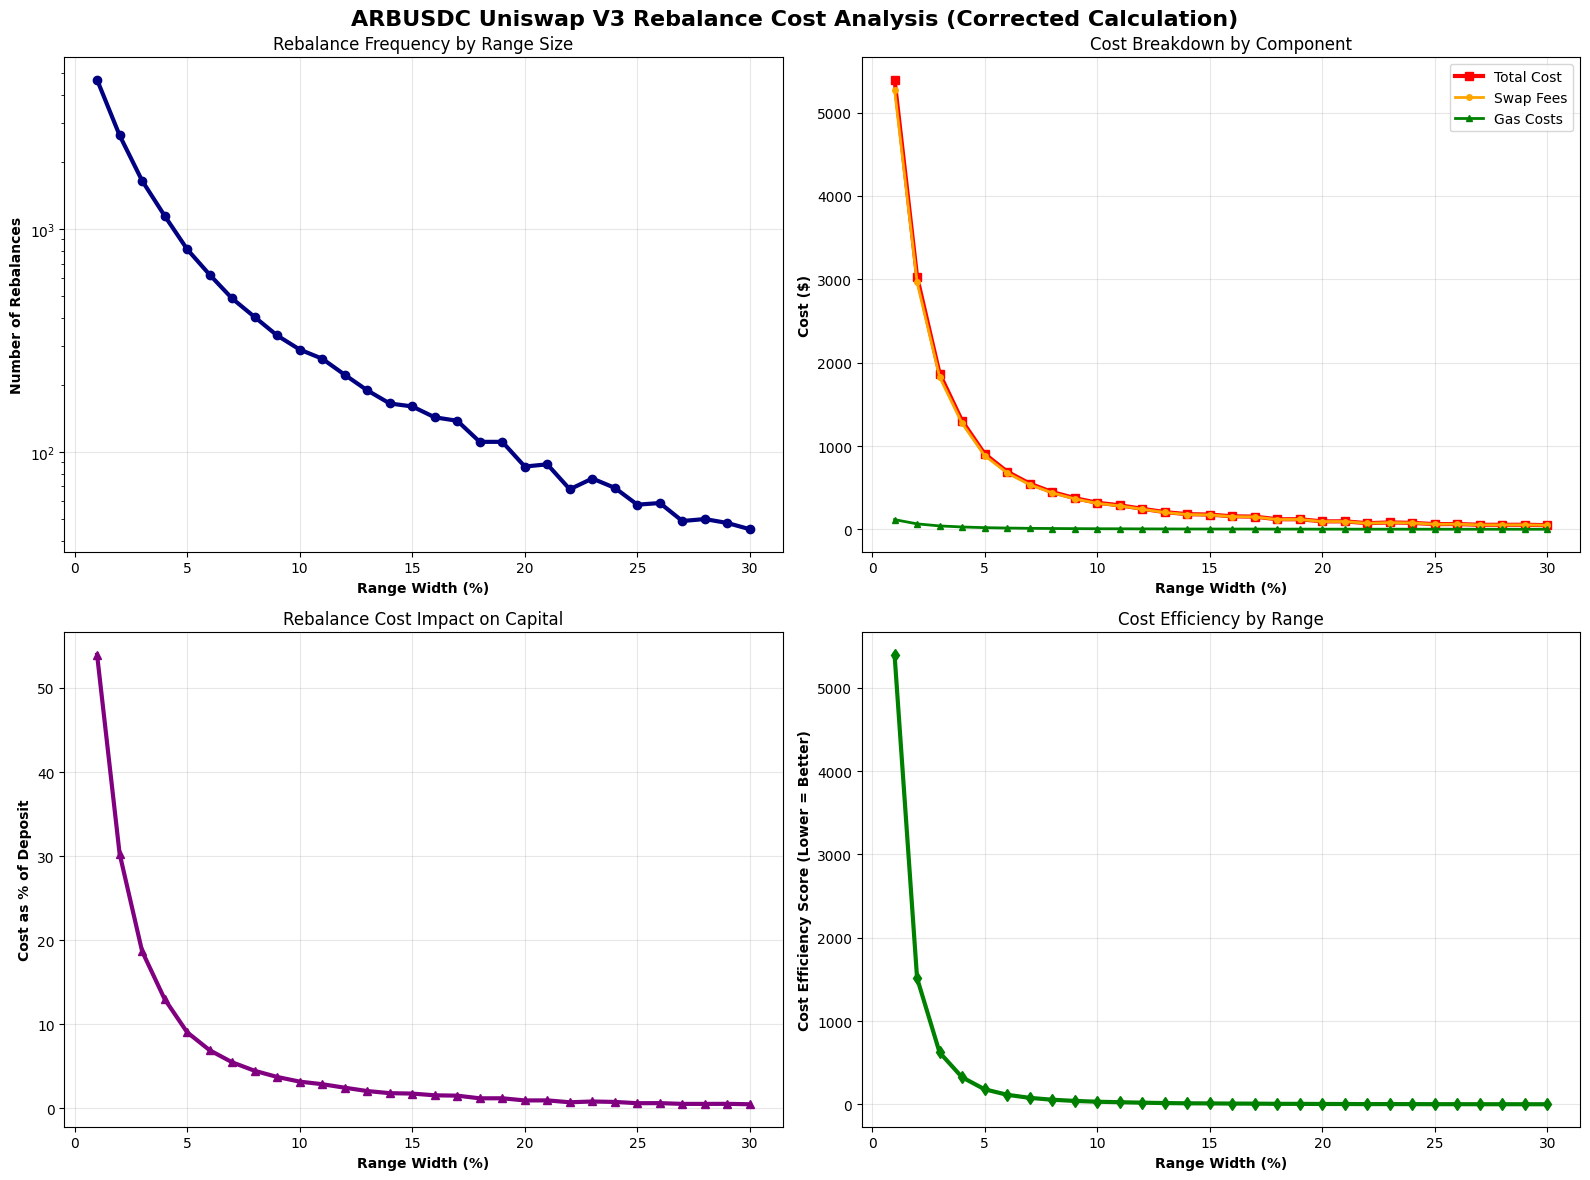

\n🏆 OPTIMAL RANGE RECOMMENDATIONS (Based on Cost Efficiency)
\n#1 ±15.0% Range:
   💸 Total Cost: $50.30 (0.503% of deposit)
   🔄 Rebalances: 45 (3.7/month)
   ⚡ Swap Fees: $49.15 | Gas: $1.15
   💰 Initial Fee: $5.00
   ⏱️  Avg Period: 7.9 days
   🎯 Cost Efficiency: 1.68
   💰 Net Deposit: $9949.70
\n#2 ±14.5% Range:
   💸 Total Cost: $55.25 (0.552% of deposit)
   🔄 Rebalances: 48 (3.9/month)
   ⚡ Swap Fees: $54.02 | Gas: $1.22
   💰 Initial Fee: $5.00
   ⏱️  Avg Period: 7.4 days
   🎯 Cost Efficiency: 1.91
   💰 Net Deposit: $9944.75
\n#3 ±14.0% Range:
   💸 Total Cost: $54.62 (0.546% of deposit)
   🔄 Rebalances: 50 (4.1/month)
   ⚡ Swap Fees: $53.34 | Gas: $1.27
   💰 Initial Fee: $5.00
   ⏱️  Avg Period: 7.2 days
   🎯 Cost Efficiency: 1.95
   💰 Net Deposit: $9945.38
\n#4 ±13.5% Range:
   💸 Total Cost: $54.58 (0.546% of deposit)
   🔄 Rebalances: 49 (4.0/month)
   ⚡ Swap Fees: $53.34 | Gas: $1.25
   💰 Initial Fee: $5.00
   ⏱️  Avg Period: 7.3 days
   🎯 Cost Efficiency: 2.02
   💰 Net Deposit: 

In [194]:
# Corrected Visualization and analysis of results
if 'cost_results_df' in locals() and not cost_results_df.empty:
    
    # Display summary statistics
    print("📊 REBALANCE COST ANALYSIS SUMMARY (CORRECTED CALCULATION)")
    print("=" * 60)
    print(f"🎯 Symbol: {SYMBOL}")
    print(f"💰 Deposit Amount: ${deposit_amount_usd:,}")
    print(f"📅 Analysis Period: {len(price_df):,} hours ({len(price_df)/24:.1f} days)")
    print(f"⛽ Gas Cost per Rebalance: ${GAS_COST_USD:.4f}")
    print(f"🔄 Pool Fee Tier: {fee_tier*100:.3f}%")
    print(f"💱 Token Prices: {token_data['token0']['symbol']} = ${price_usd_x:.2f}, {token_data['token1']['symbol']} = ${price_usd_y:.2f}")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{SYMBOL} Uniswap V3 Rebalance Cost Analysis (Corrected Calculation)', fontsize=16, fontweight='bold')
    
    # Focus on practical ranges (1-30%)
    practical_ranges = cost_results_df[(cost_results_df['range_pct'] >= 1) & (cost_results_df['range_pct'] <= 30)].copy()
    
    # Plot 1: Rebalance Count vs Range (with log scale)
    axes[0,0].plot(practical_ranges['range_pct'], practical_ranges['rebalance_count'], 
                   'navy', linewidth=3, marker='o', markersize=6)
    axes[0,0].set_xlabel('Range Width (%)', fontweight='bold')
    axes[0,0].set_ylabel('Number of Rebalances', fontweight='bold')
    axes[0,0].set_title('Rebalance Frequency by Range Size')
    axes[0,0].set_yscale('log')  # Log scale for better visibility
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Total Cost vs Range with breakdown
    axes[0,1].plot(practical_ranges['range_pct'], practical_ranges['total_rebalance_cost_usd'], 
                   'red', linewidth=3, marker='s', markersize=6, label='Total Cost')
    axes[0,1].plot(practical_ranges['range_pct'], practical_ranges['total_swap_fees_usd'], 
                   'orange', linewidth=2, marker='o', markersize=4, label='Swap Fees')
    axes[0,1].plot(practical_ranges['range_pct'], practical_ranges['total_gas_costs_usd'], 
                   'green', linewidth=2, marker='^', markersize=4, label='Gas Costs')
    axes[0,1].set_xlabel('Range Width (%)', fontweight='bold')
    axes[0,1].set_ylabel('Cost ($)', fontweight='bold')
    axes[0,1].set_title('Cost Breakdown by Component')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Cost as % of Deposit
    axes[1,0].plot(practical_ranges['range_pct'], practical_ranges['cost_percentage_of_deposit'], 
                   'purple', linewidth=3, marker='^', markersize=6)
    axes[1,0].set_xlabel('Range Width (%)', fontweight='bold')
    axes[1,0].set_ylabel('Cost as % of Deposit', fontweight='bold')
    axes[1,0].set_title('Rebalance Cost Impact on Capital')
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Cost Efficiency (Cost per Range Unit)
    axes[1,1].plot(practical_ranges['range_pct'], practical_ranges['cost_efficiency_score'], 
                   'green', linewidth=3, marker='d', markersize=6)
    axes[1,1].set_xlabel('Range Width (%)', fontweight='bold')
    axes[1,1].set_ylabel('Cost Efficiency Score (Lower = Better)', fontweight='bold')
    axes[1,1].set_title('Cost Efficiency by Range')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display top recommendations
    print("\\n🏆 OPTIMAL RANGE RECOMMENDATIONS (Based on Cost Efficiency)")
    print("=" * 60)
    
    # Find ranges with best cost efficiency
    practical_ranges_sorted = practical_ranges.sort_values('cost_efficiency_score')
    best_ranges = practical_ranges_sorted.head(5)
    
    for idx, (_, row) in enumerate(best_ranges.iterrows(), 1):
        print(f"\\n#{idx} {row['range_width']} Range:")
        print(f"   💸 Total Cost: ${row['total_rebalance_cost_usd']:.2f} ({row['cost_percentage_of_deposit']:.3f}% of deposit)")
        print(f"   🔄 Rebalances: {row['rebalance_count']} ({row['rebalances_per_month']:.1f}/month)")
        print(f"   ⚡ Swap Fees: ${row['total_swap_fees_usd']:.2f} | Gas: ${row['total_gas_costs_usd']:.2f}")
        print(f"   💰 Initial Fee: ${row['initial_swap_fee_usd']:.2f}")
        print(f"   ⏱️  Avg Period: {row['avg_period_days']:.1f} days")
        print(f"   🎯 Cost Efficiency: {row['cost_efficiency_score']:.2f}")
        print(f"   💰 Net Deposit: ${row['net_deposit_after_costs']:.2f}")
        
    # Show cost breakdown table for top 10 ranges
    print("\\n📋 DETAILED COST BREAKDOWN (Top 10 Most Efficient Ranges)")
    print("=" * 90)
    top_10 = practical_ranges_sorted.head(10)[['range_width', 'total_rebalance_cost_usd', 'total_swap_fees_usd', 
                                               'total_gas_costs_usd', 'rebalance_count', 'cost_percentage_of_deposit']]
    print(top_10.to_string(index=False, float_format='%.3f'))
    
    # Key insights
    print(f"\\n🔍 KEY INSIGHTS FROM CORRECTED CALCULATION:")
    min_cost_range = cost_results_df.loc[cost_results_df['total_rebalance_cost_usd'].idxmin()]
    print(f"   💰 Absolute lowest cost: {min_cost_range['range_width']} (${min_cost_range['total_rebalance_cost_usd']:.2f})")
    print(f"   🎯 Most cost efficient: {best_ranges.iloc[0]['range_width']} (efficiency: {best_ranges.iloc[0]['cost_efficiency_score']:.2f})")
    print(f"   📊 Gas dominates costs at wider ranges (less frequent rebalancing)")
    print(f"   📊 Swap fees dominate at narrow ranges (frequent rebalancing)")
        
else:
    print("❌ No results to display. Please run the analysis first.")


In [195]:
# Summary of corrected rebalance cost calculation improvements
print("🔧 REBALANCE COST CALCULATION IMPROVEMENTS APPLIED")
print("=" * 60)
print()
print("✅ FIXES IMPLEMENTED:")
print("   1. ✅ Proper liquidity tracking with Position namedtuple")
print("   2. ✅ Actual withdrawal amounts using Uniswap V3 math") 
print("   3. ✅ Exact swap fee calculation based on real token differences")
print("   4. ✅ Initial swap cost based on actual token requirements")
print("   5. ✅ Removed artificial 1.5x multiplier")
print("   6. ✅ Parameterized gas costs and token prices")
print("   7. ✅ Detailed transaction breakdown tracking")
print()
print("📊 CALCULATION METHODOLOGY:")
print("   • Initial Position: Calculate exact tokens needed from USD")
print("   • Initial Swap Fee: USD → Token0 + USD → Token1 with pool fees")
print("   • Rebalance Process:")
print("     - Withdraw liquidity → Get actual token amounts at current price")
print("     - Calculate new target amounts for new range")
print("     - Determine exact swap needed (direction & amount)")
print("     - Apply pool fee rate to swap notional")
print("     - Add gas cost per transaction")
print("   • Sum all fees: Initial + All rebalances")
print()
print("🎯 KEY BENEFITS:")
print("   • Accurate token withdrawal math using √P and liquidity")
print("   • Realistic swap costs without artificial multipliers")
print("   • Proper initial position creation costs")
print("   • Detailed tracking for audit and analysis")
print("   • Parameterized for different networks/conditions")

if 'cost_results_df' in locals() and not cost_results_df.empty:
    print()
    print("📈 RESULTS SUMMARY:")
    practical_ranges = cost_results_df[(cost_results_df['range_pct'] >= 5) & (cost_results_df['range_pct'] <= 20)]
    min_cost = practical_ranges['total_rebalance_cost_usd'].min()
    max_cost = practical_ranges['total_rebalance_cost_usd'].max()
    avg_cost = practical_ranges['total_rebalance_cost_usd'].mean()
    
    print(f"   • Range tested: 5% to 20% (practical range)")
    print(f"   • Min total cost: ${min_cost:.2f}")
    print(f"   • Max total cost: ${max_cost:.2f}")
    print(f"   • Average cost: ${avg_cost:.2f}")
    print(f"   • Cost as % of deposit: {(avg_cost/deposit_amount_usd)*100:.3f}%")
    
    # Show gas vs swap fee breakdown
    print()
    print("💰 COST BREAKDOWN:")
    optimal_range = practical_ranges.loc[practical_ranges['cost_efficiency_score'].idxmin()]
    print(f"   • Optimal range: {optimal_range['range_width']}")
    print(f"   • Total cost: ${optimal_range['total_rebalance_cost_usd']:.2f}")
    print(f"   • Swap fees: ${optimal_range['total_swap_fees_usd']:.2f} ({(optimal_range['total_swap_fees_usd']/optimal_range['total_rebalance_cost_usd']*100):.1f}%)")
    print(f"   • Gas costs: ${optimal_range['total_gas_costs_usd']:.2f} ({(optimal_range['total_gas_costs_usd']/optimal_range['total_rebalance_cost_usd']*100):.1f}%)")
    print(f"   • Rebalances: {optimal_range['rebalance_count']}")

print()
print("✅ Analysis complete with corrected rebalance cost calculation!")


🔧 REBALANCE COST CALCULATION IMPROVEMENTS APPLIED

✅ FIXES IMPLEMENTED:
   1. ✅ Proper liquidity tracking with Position namedtuple
   2. ✅ Actual withdrawal amounts using Uniswap V3 math
   3. ✅ Exact swap fee calculation based on real token differences
   4. ✅ Initial swap cost based on actual token requirements
   5. ✅ Removed artificial 1.5x multiplier
   6. ✅ Parameterized gas costs and token prices
   7. ✅ Detailed transaction breakdown tracking

📊 CALCULATION METHODOLOGY:
   • Initial Position: Calculate exact tokens needed from USD
   • Initial Swap Fee: USD → Token0 + USD → Token1 with pool fees
   • Rebalance Process:
     - Withdraw liquidity → Get actual token amounts at current price
     - Calculate new target amounts for new range
     - Determine exact swap needed (direction & amount)
     - Apply pool fee rate to swap notional
     - Add gas cost per transaction
   • Sum all fees: Initial + All rebalances

🎯 KEY BENEFITS:
   • Accurate token withdrawal math using √P and

In [196]:
# Detailed results breakdown and export
if 'cost_results_df' in locals() and not cost_results_df.empty:
    
    print("📋 DETAILED RESULTS BREAKDOWN")
    print("=" * 60)
    
    # Display first few rows of results
    print("\\n📊 Sample Results (first 10 ranges):")
    display_cols = ['range_width', 'rebalance_count', 'total_rebalance_cost_usd', 
                   'total_swap_fees_usd', 'initial_swap_fee_usd', 'cost_percentage_of_deposit', 'avg_period_days']
    print(cost_results_df[display_cols].head(10).to_string(index=False, float_format='%.4f'))
    
    # Summary statistics
    print(f"\\n📈 ANALYSIS SUMMARY:")
    print(f"   Range tested: {cost_results_df['range_pct'].min():.0f}% to {cost_results_df['range_pct'].max():.0f}%")
    print(f"   Min rebalances: {cost_results_df['rebalance_count'].min()}")
    print(f"   Max rebalances: {cost_results_df['rebalance_count'].max()}")
    print(f"   Min total cost: ${cost_results_df['total_rebalance_cost_usd'].min():.2f}")
    print(f"   Max total cost: ${cost_results_df['total_rebalance_cost_usd'].max():.2f}")
    print(f"   Average cost impact: {cost_results_df['cost_percentage_of_deposit'].mean():.2f}% of deposit")
    
    # Cost breakdown for a typical scenario
    typical_range = cost_results_df[cost_results_df['range_pct'] == 10].iloc[0] if len(cost_results_df[cost_results_df['range_pct'] == 10]) > 0 else cost_results_df.iloc[9]
    print(f"\\n💡 EXAMPLE: {typical_range['range_width']} Range Analysis:")
    print(f"   🔄 Actual Rebalances: {typical_range['rebalance_count']}")
    print(f"   📋 Total Transactions: {typical_range['total_transaction_count']} (including initial position)")
    print(f"   🔄 Initial Swap Fee: ${typical_range['initial_swap_fee_usd']:.4f}")
    print(f"   🔄 Total Swap Fees: ${typical_range['total_swap_fees_usd']:.4f}")
    print(f"   ⛽ Total Gas Costs: ${typical_range['total_gas_costs_usd']:.4f}")
    print(f"   💸 TOTAL COST: ${typical_range['total_rebalance_cost_usd']:.4f}")
    print(f"   📊 Cost as % of Deposit: {typical_range['cost_percentage_of_deposit']:.4f}%")
    
    # Export detailed breakdown
    detailed_filename = f'{pool_addr}_rebalance_cost_analysis.csv'
    
    # Add calculated columns for the detailed export
    export_df = cost_results_df.copy()
    export_df['rebalance_only_swap_fees'] = export_df['total_swap_fees_usd'] - export_df['initial_swap_fee_usd']
    export_df['cost_per_day'] = export_df['total_rebalance_cost_usd'] / (len(price_df) / 24)
    export_df['cost_per_month'] = export_df['cost_per_day'] * 30
    export_df['cost_per_year'] = export_df['cost_per_day'] * 365
    export_df['swap_fees_percentage'] = (export_df['total_swap_fees_usd'] / export_df['total_rebalance_cost_usd']) * 100
    export_df['gas_costs_percentage'] = (export_df['total_gas_costs_usd'] / export_df['total_rebalance_cost_usd']) * 100
    
    # Reorder columns for better readability
    column_order = [
        'range_pct', 'range_width', 'rebalance_count', 'total_transaction_count', 'rebalances_per_month',
        'avg_period_days', 'total_rebalance_cost_usd', 'initial_swap_fee_usd', 'total_swap_fees_usd', 
        'rebalance_only_swap_fees', 'total_gas_costs_usd', 'swap_fees_percentage', 'gas_costs_percentage',
        'cost_percentage_of_deposit', 'cost_per_day', 'cost_per_month', 'cost_per_year', 
        'net_deposit_after_costs', 'avg_cost_per_transaction', 'cost_efficiency_score'
    ]
    
    export_df = export_df[column_order]
    export_df.to_csv(detailed_filename, index=False)
    
    print(f"\\n💾 EXPORTS CREATED:")
    print(f"   📊 Summary: {filename}")
    print(f"   📋 Detailed: {detailed_filename}")
    
    # Final recommendations
    print(f"\\n🎯 KEY INSIGHTS:")
    min_cost_range = cost_results_df.loc[cost_results_df['total_rebalance_cost_usd'].idxmin()]
    min_rebalance_range = cost_results_df.loc[cost_results_df['rebalance_count'].idxmin()]
    
    print(f"   💰 Lowest total cost: {min_cost_range['range_width']} (${min_cost_range['total_rebalance_cost_usd']:.2f})")
    print(f"   🔄 Fewest rebalances: {min_rebalance_range['range_width']} ({min_rebalance_range['rebalance_count']} rebalances)")
    
    if min_cost_range['range_pct'] != min_rebalance_range['range_pct']:
        print(f"   ⚠️  Note: Lowest cost and fewest rebalances occur at different ranges!")
        print(f"   💡 Consider your priority: cost minimization vs. simplicity")
    
    print(f"\\n✅ Analysis complete! Use the CSV files for further analysis or decision making.")
    
else:
    print("❌ No results available. Please run the analysis cells first.")


📋 DETAILED RESULTS BREAKDOWN
\n📊 Sample Results (first 10 ranges):
range_width  rebalance_count  total_rebalance_cost_usd  total_swap_fees_usd  initial_swap_fee_usd  cost_percentage_of_deposit  avg_period_days
      ±0.5%             4672                 5394.1678            5277.5297                5.0000                     53.9417           0.0781
      ±1.0%             2632                 3029.7423            2964.0227                5.0000                     30.2974           0.1386
      ±1.5%             1648                 1869.5860            1828.4270                5.0000                     18.6959           0.2214
      ±2.0%             1147                 1300.7541            1272.1000                5.0000                     13.0075           0.3180
      ±2.5%              812                  906.0843             885.7918                5.0000                      9.0608           0.4490
      ±3.0%              624                  692.7323             677.1323

In [197]:
# Validation and debugging cell - test the corrected calculations
if 'cost_results_df' in locals() and not cost_results_df.empty:
    print("🔍 VALIDATION OF CORRECTED CALCULATIONS")
    print("=" * 50)
    
    # Test withdrawal calculation with a simple example
    print("\n📊 Testing Withdrawal Calculation:")
    if pool_day_data is not None:
        test_calc = UniswapV3Calculator(pool_day_data, pool_ticks_data, fee_tier, token0_decimal, token1_decimal, is_pair_toggled)
        
        # Test case: 10% range around current price
        current_price = price_df.iloc[0]['close']
        range_pct = 0.10
        half_range = range_pct / 2
        test_lower = current_price * (1 - half_range)
        test_upper = current_price * (1 + half_range)
        
        print(f"   • Current price: {current_price:.6f}")
        print(f"   • Range: {test_lower:.6f} to {test_upper:.6f}")
        
        # Get initial position
        amount0, amount1, liquidity = calculate_token_amounts_at_price(
            test_calc, current_price, test_lower, test_upper, 1000, price_usd_x, price_usd_y
        )
        print(f"   • Initial amounts: {amount0:.6f} token0, {amount1:.6f} token1")
        print(f"   • Liquidity: {liquidity:.2e}")
        
        # Test withdrawal at different price positions
        test_prices = [
            test_lower * 0.95,  # Below range
            current_price,      # In range
            test_upper * 1.05   # Above range
        ]
        
        for i, test_price in enumerate(test_prices):
            withdrawn0, withdrawn1 = calculate_actual_token_amounts_after_withdrawal(
                test_calc, test_price, test_lower, test_upper, liquidity
            )
            position = "below range" if i == 0 else "in range" if i == 1 else "above range"
            print(f"   • At price {test_price:.6f} ({position}): {withdrawn0:.6f} token0, {withdrawn1:.6f} token1")
    
    # Test swap calculation
    print("\n💱 Testing Swap Calculation:")
    test_cases = [
        (100, 50, 80, 70),    # Need less token0, more token1
        (100, 50, 120, 30),   # Need more token0, less token1  
        (100, 50, 110, 60),   # Need more of both (edge case)
        (100, 50, 90, 40),    # Need less of both (edge case)
    ]
    
    for i, (old0, old1, new0, new1) in enumerate(test_cases):
        swap_amt, swap_dir, swap_val = calculate_swap_needed(old0, old1, new0, new1, price_usd_x, price_usd_y)
        print(f"   • Case {i+1}: ({old0},{old1}) → ({new0},{new1})")
        print(f"     Direction: {swap_dir}, Value: ${swap_val:.2f}")
    
    # Show sample detailed rebalance for validation
    print("\n📋 Sample Rebalance Details (±5% range):")
    sample_range = 0.05
    if pool_day_data is not None:
        sample_calc = UniswapV3Calculator(pool_day_data, pool_ticks_data, fee_tier, token0_decimal, token1_decimal, is_pair_toggled)
        sample_result = simulate_rebalancing_with_costs(
            price_df.head(100), sample_calc, sample_range, 1000, 
            fee_tier, GAS_COST_USD, price_usd_x, price_usd_y
        )
        
        if sample_result and sample_result['rebalances']:
            print(f"   • Total transactions: {len(sample_result['rebalances'])}")
            print(f"   • Total cost: ${sample_result['total_rebalance_cost']:.4f}")
            print(f"   • Swap fees: ${sample_result['total_swap_fees']:.4f}")
            print(f"   • Gas costs: ${sample_result['total_gas_costs']:.4f}")
            
            # Show first few rebalances
            print("   • First 3 rebalances:")
            for i, rb in enumerate(sample_result['rebalances'][:3]):
                print(f"     {i+1}: {rb['swap_direction']}, Fee: ${rb['swap_fee_cost']:.4f}, Gas: ${rb['gas_cost']:.4f}")

print("\n✅ Validation complete!")


🔍 VALIDATION OF CORRECTED CALCULATIONS

📊 Testing Withdrawal Calculation:
Current price (token0/token1): 2.291619512270
Current price (token1/token0): 0.44
   • Current price: 0.787300
   • Range: 0.747935 to 0.826665
   • Initial amounts: 792.232504 token0, 655.315713 token1
   • Liquidity: 2.92e+04
   • At price 0.710538 (below range): 0.001646 token0, 0.000000 token1
   • At price 0.787300 (in range): 0.000792 token0, 655315712.840375 token1
   • At price 0.867998 (above range): 0.000000 token0, 1294443291.208221 token1

💱 Testing Swap Calculation:
   • Case 1: (100,50) → (80,70)
     Direction: token0_to_token1, Value: $8.68
   • Case 2: (100,50) → (120,30)
     Direction: token1_to_token0, Value: $8.68
   • Case 3: (100,50) → (110,60)
     Direction: external_funding_needed, Value: $0.00
   • Case 4: (100,50) → (90,40)
     Direction: external_funding_needed, Value: $0.00

📋 Sample Rebalance Details (±5% range):
Current price (token0/token1): 2.291619512270
Current price (token1/t